In [164]:
import numpy as np
import os
import math
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy

----------------
#### Sequential features extraction

Change 2 features(x, y coordinates) to 3 features(velocity, angle, angular velocity) for each time step.

In [3]:
classname_list = os.listdir("npy")
for classfile in classname_list:
    class_3seq = np.zeros((1,59,3)) 
    classfile_path = os.path.join("npy",classfile)
    class_coor = np.load(classfile_path)

    for sample_coor in class_coor:
        sample_3seq = np.zeros((59,3))
        
        for n in range(60):
            if n>0:
                xdiff = sample_coor[n][0] - sample_coor[n-1][0]
                ydiff = sample_coor[n][1] - sample_coor[n-1][1]
                v = math.sqrt(math.pow(xdiff,2) + math.pow(ydiff,2))
                ang = math.atan((sample_coor[n][1]-sample_coor[n-1][1])/(sample_coor[n][0]-sample_coor[n-1][0]))
                if n>1:
                    av = ang - sample_3seq[n-2][1]
                else: av = 0
                sample_3seq[n-1] = np.array([v, ang, av])
        sample_3seq = sample_3seq[np.newaxis, :, :]
        class_3seq = np.append(class_3seq, sample_3seq, axis=0)
        
    class_3seq = np.delete(class_3seq, 0, axis=0)
    print(class_3seq.shape)
    class3seq_path = os.path.join("npy",classfile[:-4]+"_3seq.npy")
    np.save(class3seq_path, class_3seq)

(1263, 59, 3)
(808, 59, 3)
(990, 59, 3)
(1061, 59, 3)
(981, 59, 3)


----------------------
#### Pause event criteria
1. define local minimum velocity:
![](https://latex.codecogs.com/gif.latex?v_%7B%5Ctext%7Bmin%7D%7D%20%3C%20%5CDelta%20v/2)
2. define the duration of low velocity:
![](https://latex.codecogs.com/gif.latex?v_%7B%5Ctext%7Bend%7D%7D%20%3C%20v_%7B%5Ctext%7Bmin%7D%7D%20&plus;%200.2%5CDelta%20v_%7B%5Ctext%7Bmax%7D%7D)
<img src="http://i68.tinypic.com/ajq70n.jpg" alt="drawing" width="350"/>

#### Reversal event criteria
1. define the duration by angular velocity:
![](https://latex.codecogs.com/gif.latex?t_%7B%5Ctext%7Bend1%7D%7D%20-%20t_%7B%5Ctext%7Bend2%7D%7D%20%3D%20w_%7B%5Ctext%7Bmin1%7D%7D%20-%20w_%7B%5Ctext%7Bmin2%7D%7D)
2. cut out small angle change:
![](https://latex.codecogs.com/gif.latex?%7C%5CDelta%20%5CTheta%20%7C%3E%5Cpi/2)
![](https://latex.codecogs.com/gif.latex?%7C%5CDelta%20%5CTheta%20%7C%3E7%5Csqrt%7B0.1%28t_%7B%5Ctext%7Bend1%7D%7D%20-%20t_%7B%5Ctext%7Bend2%7D%7D%29%7D)
<img src="http://i68.tinypic.com/15dm2w7.jpg" alt="drawing" width="350"/>

In [572]:
def VSeq2PauseSeq(VSeq):
    PauseSeq = [0]*VSeq.shape[0]
    minIdx = np.asarray(scipy.signal.argrelmin(VSeq))[0]
    maxIdx = np.asarray(scipy.signal.argrelmax(VSeq))[0]
    mergeIdx = np.concatenate((np.column_stack((minIdx,[-1]*minIdx.shape[0])), 
                               np.column_stack((maxIdx,[1]*maxIdx.shape[0]))), axis=0)
    mergeIdx=mergeIdx[np.argsort(mergeIdx, axis=0)[:,0]]
    
    for i in range(len(mergeIdx)):
        if mergeIdx[i][1] == -1:
            if i==0: deltav = max((VSeq[0]-VSeq[mergeIdx[i][0]]), (VSeq[mergeIdx[i+1][0]]-VSeq[mergeIdx[i][0]]))
            elif i==(len(mergeIdx)-1): deltav = max((VSeq[-1]-VSeq[mergeIdx[i][0]]),
                                                    (VSeq[mergeIdx[i-1][0]]-VSeq[mergeIdx[i][0]]))
            else:deltav = max((VSeq[mergeIdx[i-1][0]]-VSeq[mergeIdx[i][0]]),(VSeq[mergeIdx[i+1][0]]-VSeq[mergeIdx[i][0]]))
            
            if VSeq[mergeIdx[i][0]]<0.5*deltav:
                Index_endleft = None; Index_endright = None 
                v_upper = VSeq[mergeIdx[i][0]] + 0.2*deltav
                VSeq_left = np.flip(VSeq[:mergeIdx[i][0]], 0)
                VSeq_right = VSeq[mergeIdx[i][0]:]
                
                for n in range(VSeq_left.shape[0]):
                    if VSeq_left[n]>v_upper:break
                    Index_endleft = mergeIdx[i][0]-n-1
                for m in range(VSeq_right.shape[0]):
                    if VSeq_right[m]>v_upper:break
                    Index_endright = mergeIdx[i][0]+m
                if Index_endleft is None: Index_endleft = mergeIdx[i][0]
                if Index_endright is None: Index_endright = mergeIdx[i][0]
                if Index_endleft!=Index_endright:
                    PauseSeq[Index_endleft:Index_endright+1] = [1]*(Index_endright-Index_endleft+1)  
    return PauseSeq

def AngAvSeq2ReversalSeq(AngSeq, AvSeq):
    ReversalSeq = [0]*AngSeq.shape[0]
    minIdx = np.asarray(scipy.signal.argrelmin(AvSeq))[0]
    for i in range(len(minIdx)-1):
        max_i = max(AngSeq[minIdx[i]:minIdx[i+1]+1])
        min_i = min(AngSeq[minIdx[i]:minIdx[i+1]+1])
        deltaang = max_i-min_i
        if deltaang>0.5*math.pi and deltaang>7*math.sqrt((minIdx[i+1]-minIdx[i])/300):
            ReversalSeq[minIdx[i]:minIdx[i+1]+1]=[1]*(minIdx[i+1]-minIdx[i]+1)
    return ReversalSeq
    
def PlotPause(VSeq):
    BinSeq=VSeq2PauseSeq(VSeq)   
    BinSeq = [0]+BinSeq+[0]
    x_plot = []
    for i in range(1, len(BinSeq)-2):
        if BinSeq[i]!=0 and BinSeq[i-1]==0:start = i
        elif BinSeq[i]!=0 and BinSeq[i+1]==0:
            end = i; x_plot.append([start-1, end-1])        
    plt.figure(figsize=(10, 3), dpi=400)
    plt.plot(VSeq, color='deepskyblue')
    for event_pair in x_plot:
        x = []; y =[]
        for i in range(event_pair[0], event_pair[1]+1):
            x.append(i);y.append(VSeq[i])
        plt.plot(x, y, color='navy')
    plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='Non Event'), 
                        mpatches.Patch(color='navy', label='Pause')])
    plt.xlabel("time step")
    plt.ylabel("velocity")
    plt.show()
    
def PlotReversal(AngSeq, AvSeq):
    BinSeq=AngAvSeq2ReversalSeq(AngSeq, AvSeq)
    BinSeq = [0]+BinSeq+[0]
    x_plot = []
    for i in range(1, len(BinSeq)-2):
        if BinSeq[i]!=0 and BinSeq[i-1]==0:start = i
        elif BinSeq[i]!=0 and BinSeq[i+1]==0:
            end = i; x_plot.append([start-1, end-1]) 
    plt.figure(figsize=(10, 3), dpi=400)
    plt.plot(AvSeq, color='deepskyblue')
    for event_pair in x_plot:
        x = []; y =[]
        for i in range(event_pair[0], event_pair[1]+1):
            x.append(i);y.append(AvSeq[i])
        plt.plot(x, y, color='navy')
        
    plt.legend(handles=[mpatches.Patch(color='deepskyblue', label='Non Event'), 
                        mpatches.Patch(color='navy', label='Reversal')])
    plt.xlabel("time step")
    plt.ylabel("angualr velocity")
    plt.show()
    
    plt.figure(figsize=(10, 3), dpi=400)
    plt.plot(AngSeq, color='orange')
    for event_pair in x_plot:
        x = []; y =[]
        for i in range(event_pair[0], event_pair[1]+1):
            x.append(i);y.append(AngSeq[i])
        plt.plot(x, y, color='firebrick')
    plt.legend(handles=[mpatches.Patch(color='orange', label='Non Event'), 
                        mpatches.Patch(color='firebrick', label='Reversal')])
    plt.xlabel("time step")
    plt.ylabel("angles")
    plt.show()

#### Demo

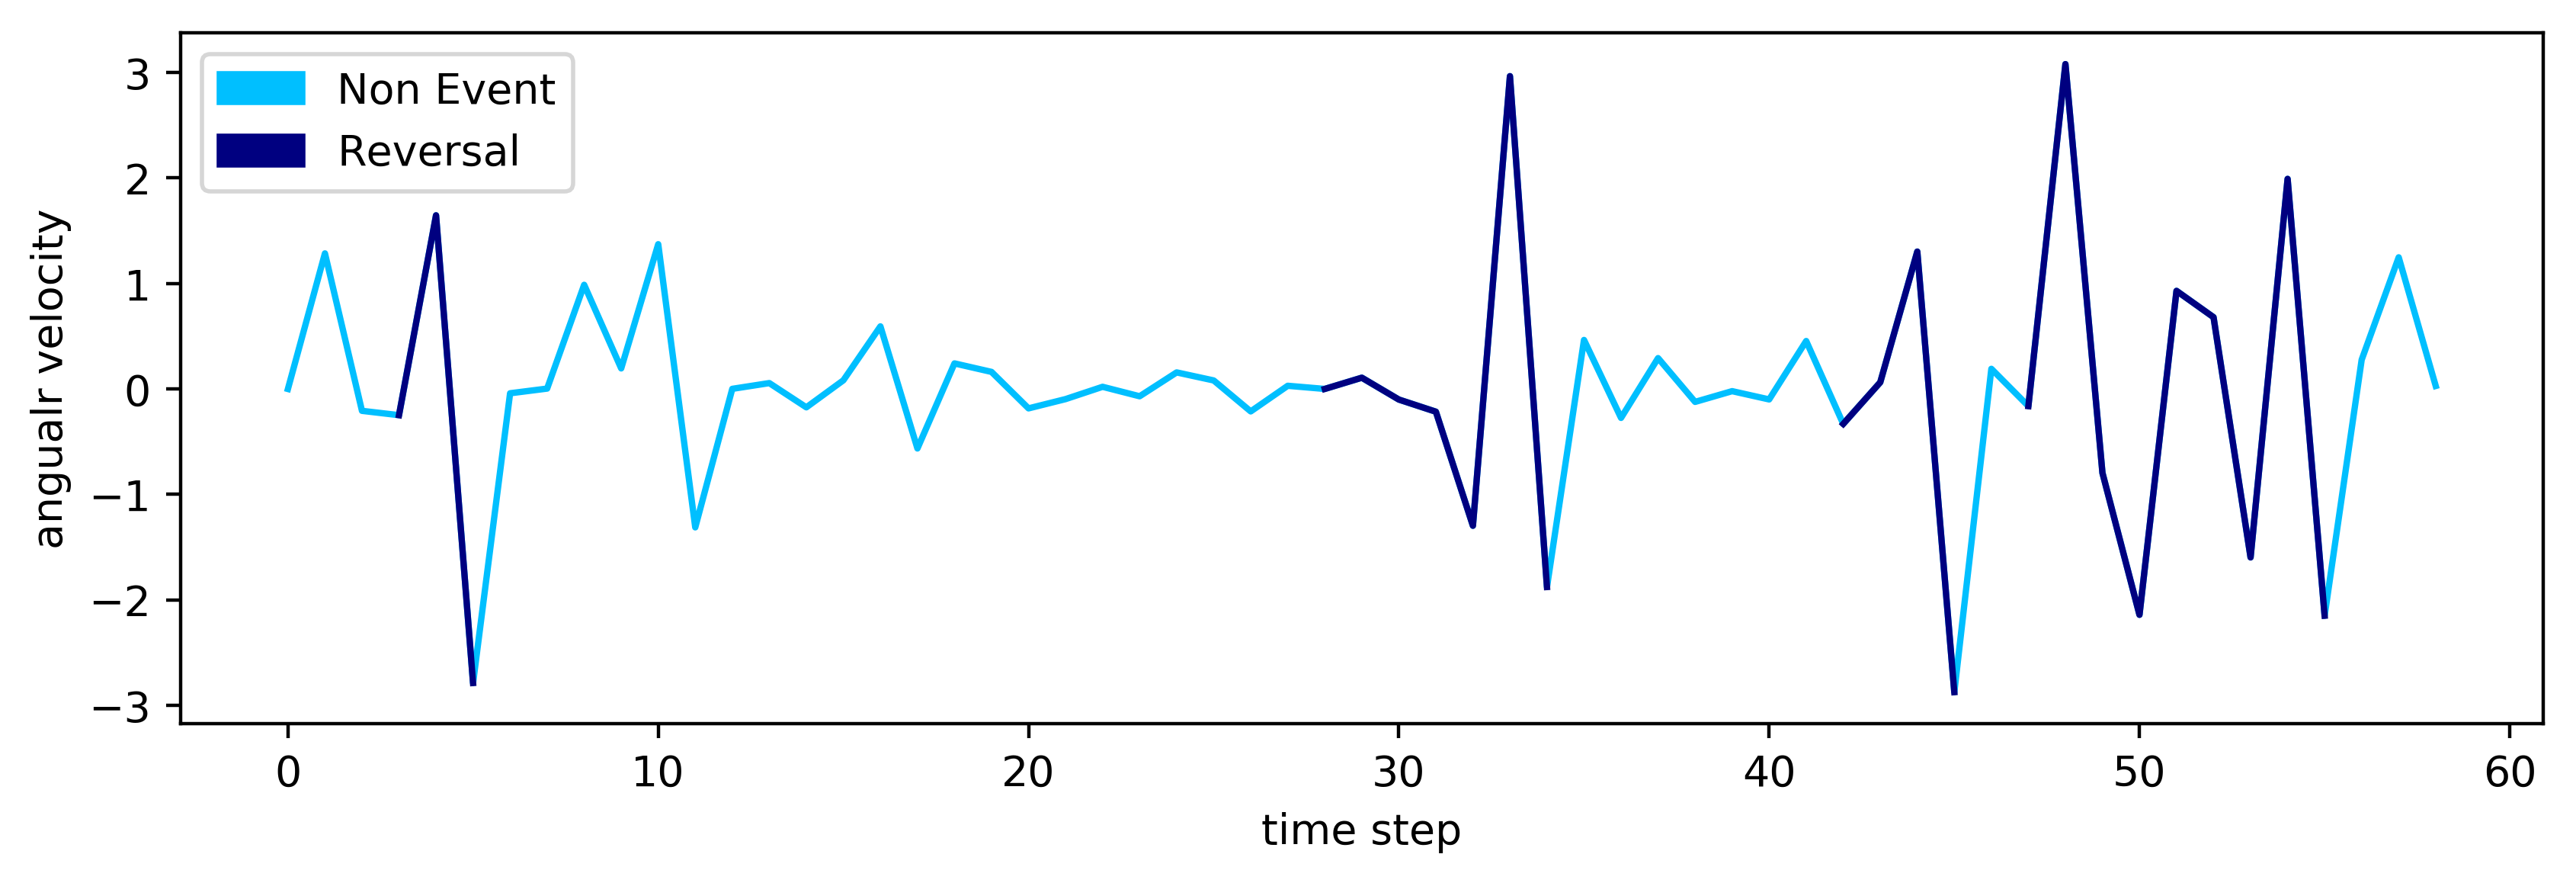

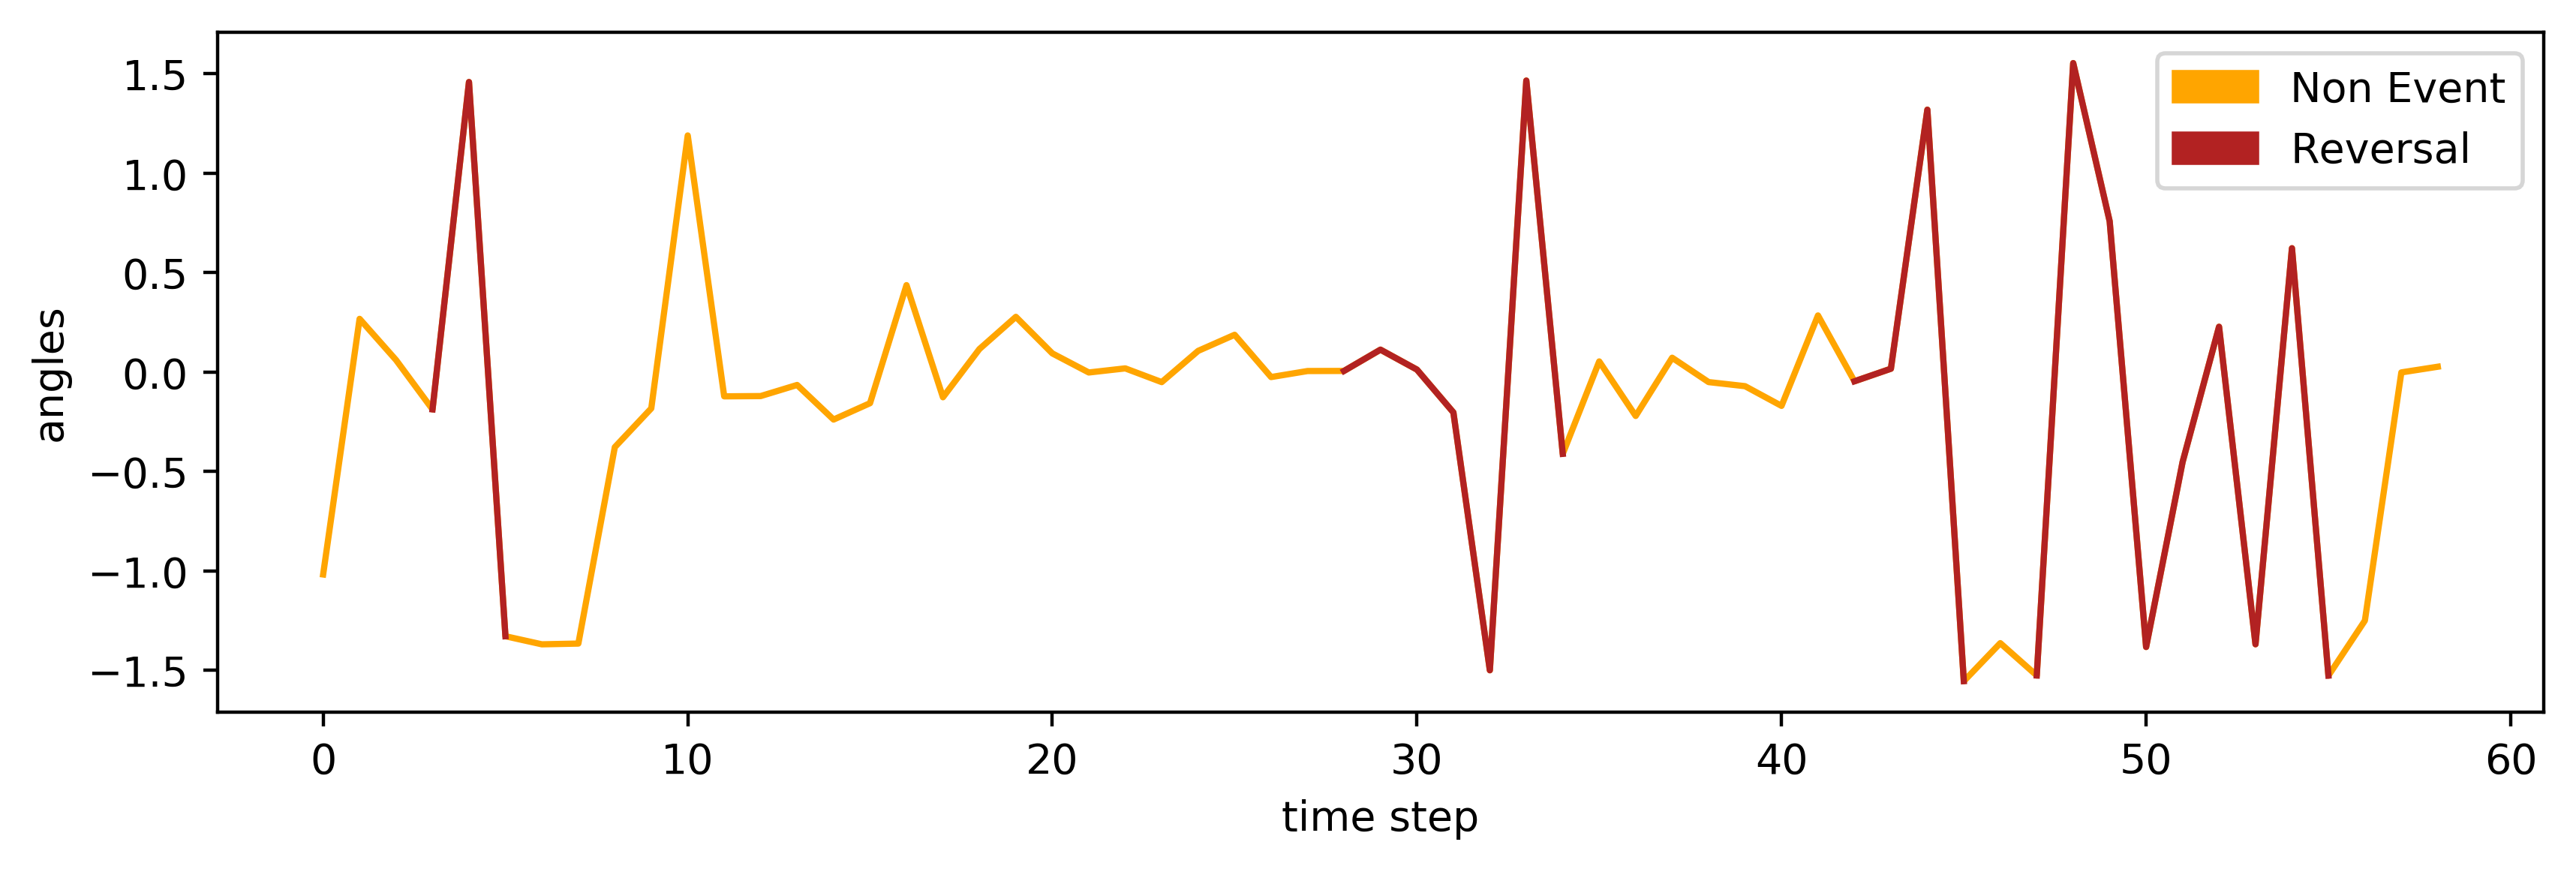

In [573]:
data = np.load('x.npy') 
data = data[500, :, :]
ang = data[:,1]
av = data[:,2]
PlotReversal(ang, av)

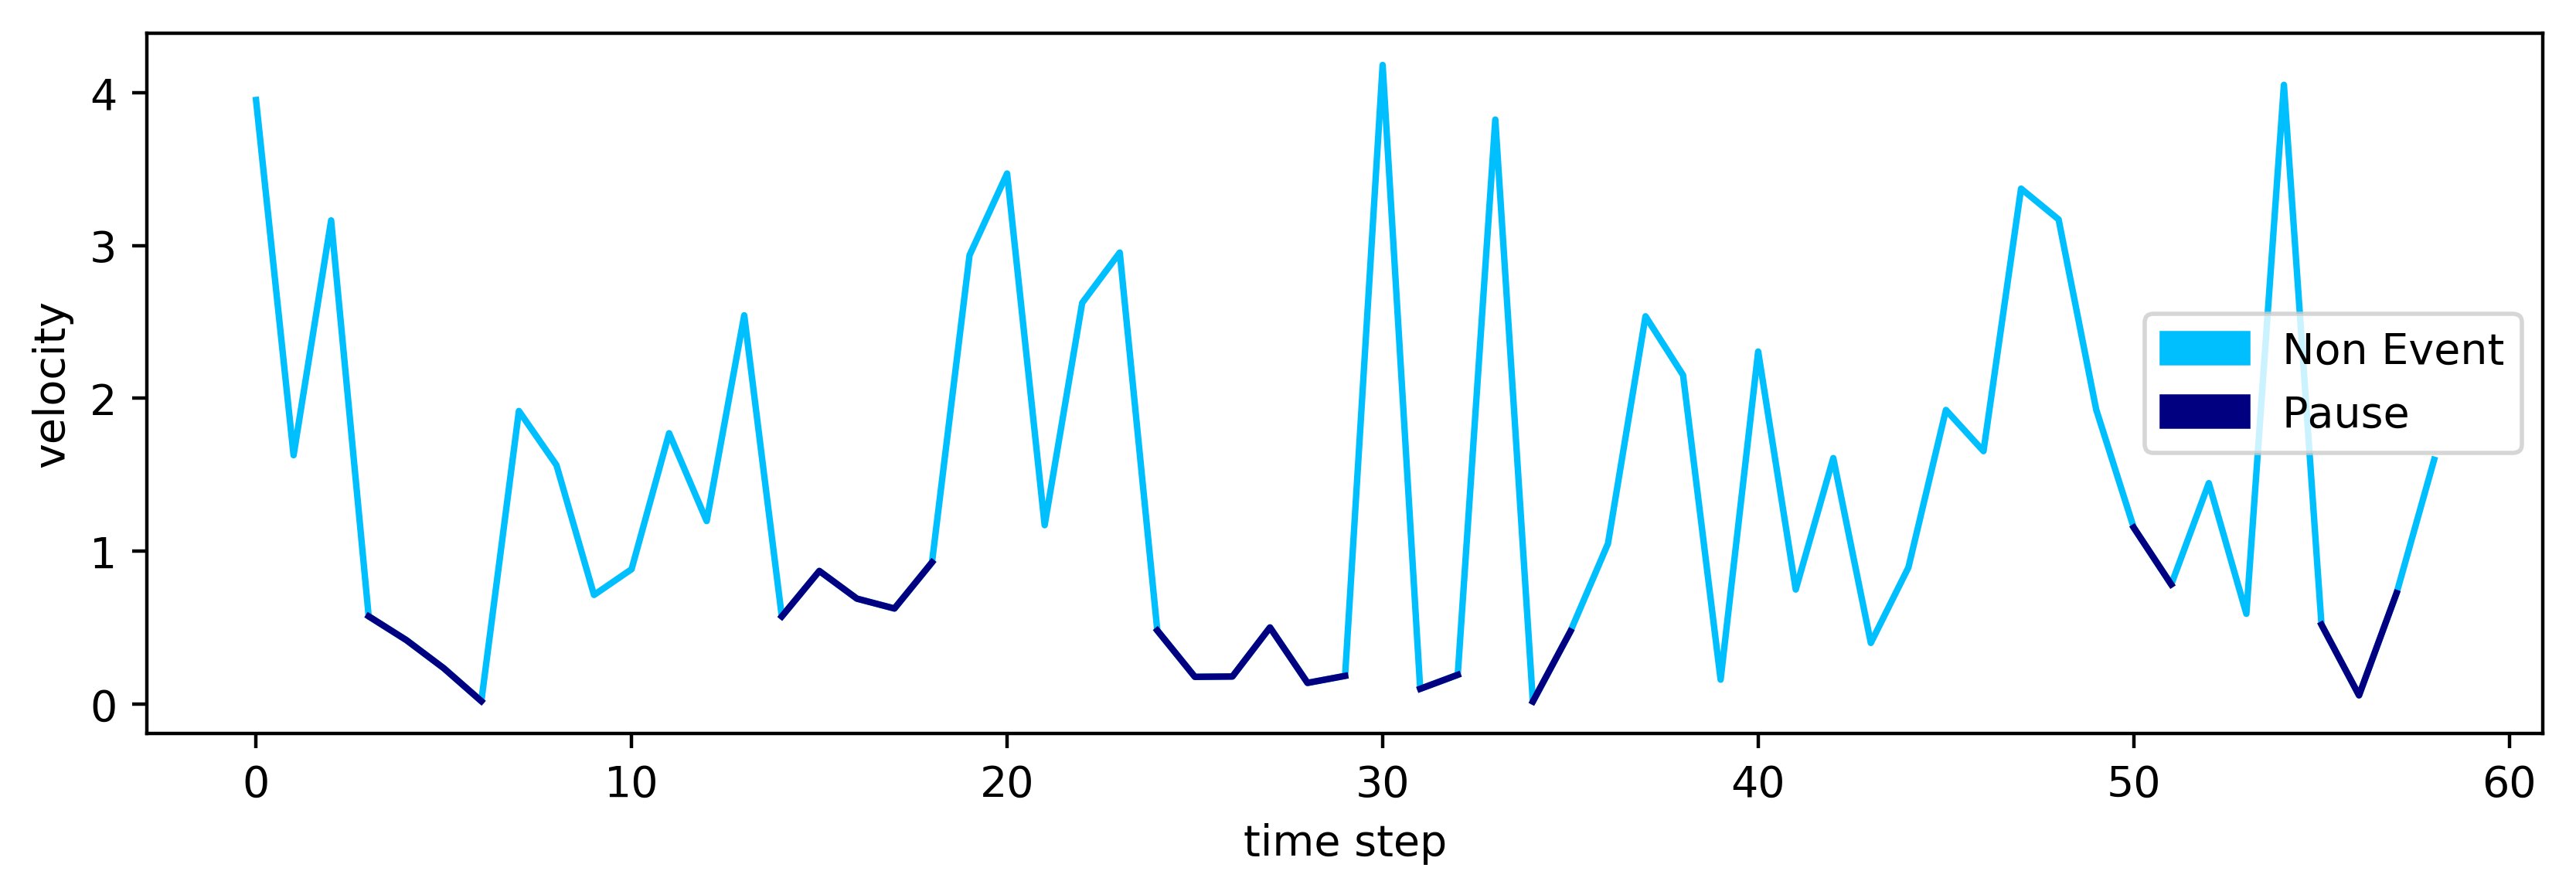

In [574]:
data = np.load('x.npy') 
data = data[100, :, :]
v = data[:,0]
PlotPause(v)

#### Generate event labels
The label is a binery sequence. 1 for event, 0 for non-event. Each sample will have two label sequences.

In [588]:
classname_list = os.listdir("3seq")
for classfile in classname_list:
    class_2EventSeq = np.zeros((1,59,2)) 
    classfile_path = os.path.join("3seq",classfile)
    class_3seq = np.load(classfile_path)
    
    for sample in class_3seq:
        PauseSeq =  VSeq2PauseSeq(sample[:,0])
        ReversalSeq = AngAvSeq2ReversalSeq(sample[:,1], sample[:,2])
        EventSeq = np.column_stack((PauseSeq, ReversalSeq))
        EventSeq = EventSeq[np.newaxis, :, :]
        class_2EventSeq = np.append(class_2EventSeq, EventSeq, axis=0)
    
    class_2EventSeq = np.delete(class_2EventSeq, 0, axis=0)
    class2EventSeq_path = os.path.join("npy",classfile[:-8]+"2EventSeq.npy")
    print(class2EventSeq_path, "is saved")
    np.save(class2EventSeq_path, class_3seq)

npy\Class1_S7_1263_2EventSeq.npy is saved
npy\Class2_A1_808_2EventSeq.npy is saved
npy\Class3_A4_990_2EventSeq.npy is saved
npy\Class4_Y1_1061_2EventSeq.npy is saved
npy\Class5_Y4_981_2EventSeq.npy is saved
